### Load in our accuracies for FICO

In [2]:
import pandas as pd
dfs = []
for s_iter in range(50):
    #df = pd.read_csv(f'./parallelized_results/baselines_2024-01-28_iter_{s_iter}_MICE_imp_10_imp.csv')
    df = pd.read_csv(f'./parallelized_results/baselines_2024-02-25_iter_{s_iter}_10_imp_all_50_max_coef.csv')
    dfs.append(df)
combined_acc_df = pd.concat(dfs, axis=0)

In [10]:
import pandas as pd
dfs = []
for s_iter in range(50):
    df = pd.read_csv(f'./parallelized_results/baselines_2024-01-31_iter_{s_iter}_10_imp_all.csv')
    dfs.append(df)
combined_acc_df = pd.concat(dfs, axis=0)


In [8]:
import pandas as pd
dfs = []
for ds_name in ['CKD']:
    for imputation_method in ['Mean']:
        for s_iter in range(11):
            #df = pd.read_csv(f'./parallelized_results/baselines_2024-02_01_iter_{s_iter}_10_imp_all.csv')
            df = pd.read_csv(f'./parallelized_results/baselines_iter_{s_iter}_{ds_name}_{imputation_method}.csv')
            dfs.append(df)
combined_acc_df = pd.concat(dfs, axis=0)

target_imp = 'Mean'

In [9]:
mask = (combined_acc_df['num_imputations'] == 10) & \
        (combined_acc_df['missingness_handling'] == target_imp)
cur_acc_df = combined_acc_df[mask]

In [10]:
cur_acc_df = cur_acc_df.groupby(['model_type', 'dataset', 'holdout_set', 'metric', 'missingness_handling']).mean().reset_index()
cur_acc_df['model_type'].value_counts()

/tmp/ipykernel_3556993/2418782196.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cur_acc_df = cur_acc_df.groupby(['model_type', 'dataset', 'holdout_set', 'metric', 'missingness_handling']).mean().reset_index()


GAM_aug                   30
GAM_ind                   30
GAM_no_missing            30
LogisticRegression        30
RandomForestClassifier     3
Name: model_type, dtype: int64

In [11]:
# Because we have a distinct entry for each val set for our gams,
# we need to take the average of each value along val sets
cur_acc_df = cur_acc_df.groupby(['model_type', 'dataset', 'holdout_set', 'metric', 'missingness_handling']).mean().reset_index()

# Now lets filter down to grab just AUC for BRECA, ACC for FICO
#cur_acc_df = pd.concat([
    #cur_acc_df[(cur_acc_df['dataset'] == 'FICO') & (cur_acc_df['metric'] == 'acc')],
    #cur_acc_df[(cur_acc_df['dataset'] == 'BREAST_CANCER') & (cur_acc_df['metric'] == 'auc')]
#], axis=0)
cur_acc_df = cur_acc_df[cur_acc_df['metric'] == 'auc']


cur_acc_df = cur_acc_df[cur_acc_df['model_type'] != 'GAM_no_missing']

cur_acc_df['Model Type'] = cur_acc_df['model_type']
cur_acc_df.loc[cur_acc_df['Model Type'] == 'GAM_imputation', 'Model Type'] = 'GAM (Imputation)'
cur_acc_df.loc[cur_acc_df['Model Type'] == 'GAM_ind', 'Model Type'] = 'GAM (Indicators)'
cur_acc_df.loc[cur_acc_df['Model Type'] == 'GAM_aug', 'Model Type'] = 'GAM (Interactions)'

cur_acc_df.loc[cur_acc_df['dataset'] == 'BREAST_CANCER', 'dataset'] = 'Breast Cancer'

cur_acc_df = cur_acc_df.sort_values('Model Type')

In [12]:
cur_acc_df

,model_type,dataset,holdout_set,metric,missingness_handling,metric_value_train,metric_value_test,std_fit_time,mean_fit_time,num_imputations,smim_time,Model Type
46,GAM_ind,CKD,5,auc,Mean,0.999987,1.000000,0.000000,0.141819,10.0,NaN,GAM (Indicators)
58,GAM_ind,CKD,9,auc,Mean,1.000000,0.999451,0.000000,0.138827,10.0,NaN,GAM (Indicators)
55,GAM_ind,CKD,8,auc,Mean,1.000000,1.000000,0.000000,0.139519,10.0,NaN,GAM (Indicators)
52,GAM_ind,CKD,7,auc,Mean,0.999993,0.999405,0.000000,0.143907,10.0,NaN,GAM (Indicators)
49,GAM_ind,CKD,6,auc,Mean,0.999977,1.000000,0.000000,0.107694,10.0,NaN,GAM (Indicators)
43,GAM_ind,CKD,4,auc,Mean,0.999973,0.992000,0.000000,0.114949,10.0,NaN,GAM (Indicators)
40,GAM_ind,CKD,3,auc,Mean,1.000000,1.000000,0.000000,0.146754,10.0,NaN,GAM (Indicators)
37,GAM_ind,CKD,2,auc,Mean,1.000000,1.000000,0.000000,0.111418,10.0,NaN,GAM (Indicators)
34,GAM_ind,CKD,1,auc,Mean,1.000000,1.000000,0.000000,0.085662,10.0,NaN,GAM (Indicators)
31,GAM_ind,CKD,0,auc,Mean,1.000000,1.000000,0.000000,0.097388,10.0,NaN,GAM (Indicators)


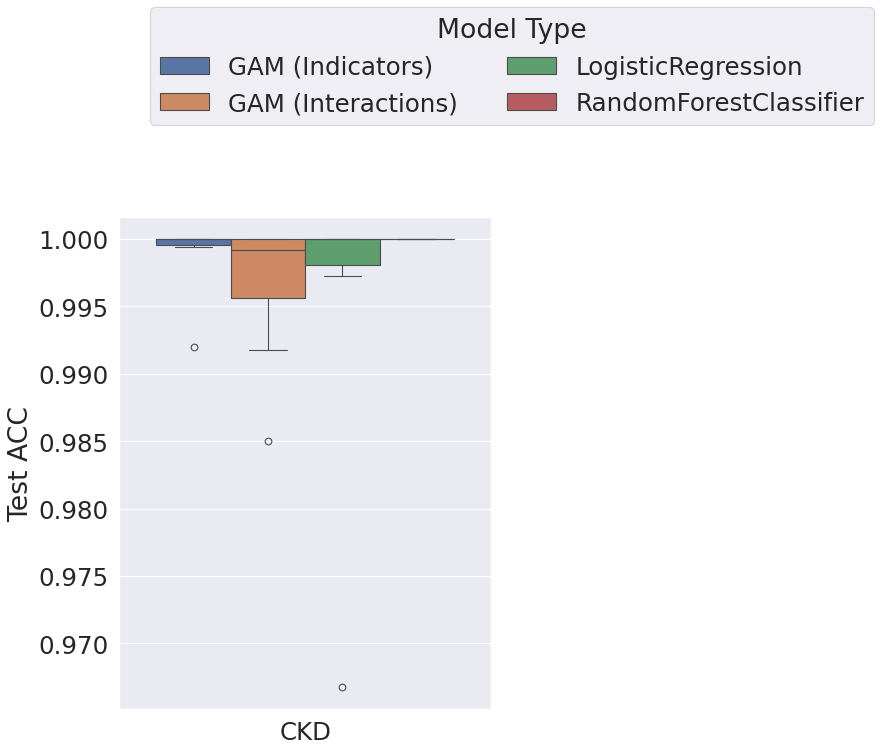

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

#for dataset in acc_res['dataset'].unique():
#mask = acc_res['dataset'] == dataset
sns.set(font_scale=2.0)
figure(figsize=(6, 8), dpi=80)
ax = sns.boxplot(
    cur_acc_df, hue='Model Type', y='metric_value_test', x='dataset'
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.05, 1.45), ncol=2)
plt.xlabel('')
#plt.ylim((0.75, 0.85))
#plt.title(dataset)
plt.ylabel('Test ACC')
plt.xticks(rotation=0, ha='center')
plt.show()

### Turning to consider alternative imputation strategies 

Load in our timing data for each imputation method (over 10 imputations)

In [17]:
import pandas as pd
df_list = [
    pd.read_csv(f'../../handling_missing_data/timing_stats_10_val_2024-01-28_all_BREAST_CANCER_GAIN.csv'),
    pd.read_csv(f'../../handling_missing_data/timing_stats_10_val_2024-01-28_all_FICO_GAIN.csv'),
    #pd.read_csv(f'../../handling_missing_data/timing_stats_10_val_2024-01-28_all_FICO_MissForest.csv'),
    pd.read_csv(f'../../handling_missing_data/timing_stats_10_val_2024-01-29_all_FICO_MIWAE.csv'),
]
for dataset in ['BREAST_CANCER', 'FICO']:
    try:
        df_list.append(pd.read_csv(f'../../handling_missing_data/timing_stats_10_val_2024-01-27_all_{dataset}.csv'))
    except:
        df_list.append(pd.read_csv(f'../../handling_missing_data/timing_stats_10_val_2024-01-27_all_{dataset}.csv'))
base_timing_df = pd.concat(df_list, axis=0)
base_timing_df['dataset'].value_counts()

FICO             3500
BREAST_CANCER    3464
Name: dataset, dtype: int64

In [18]:
base_timing_df = base_timing_df[base_timing_df['m'] < 10]
base_timing_df['imputation'].value_counts()

Mean          1000
MissForest    1000
MIWAE         1000
GAIN          1000
MICE           990
Name: imputation, dtype: int64

In [19]:
tmp_df = base_timing_df.groupby(['dataset', 'holdout_set', 'imputation', 'validation_set']).sum()
tmp_df = tmp_df.groupby(['dataset', 'holdout_set', 'imputation']).mean()

# For MICE, time_overall has the total time, and all the others are 0;
# The opposite holds for the other methods
tmp_df['time_overall'] = tmp_df['time_overall'] + tmp_df['time_for_test'] \
    + tmp_df['time_for_val'] + tmp_df['time_for_train'] + tmp_df['time_to_fit'] 
tmp_df = tmp_df.reset_index()

mask = (combined_acc_df['num_imputations'] == 10)\
     & (combined_acc_df['missingness_handling'] != 'GAIN')\
     & (combined_acc_df['metric'] == 'auc') & (combined_acc_df['dataset'] == 'BREAST_CANCER')
     #& (combined_acc_df['metric'] == 'acc') & (combined_acc_df['dataset'] == 'FICO')
acc_df = combined_acc_df[mask]
tmp_df_acc = acc_df.groupby(['dataset', 'holdout_set', 'model_type', 'missingness_handling']).mean().reset_index()
tmp_df_acc['imputation'] = tmp_df_acc['missingness_handling']

merged_df = tmp_df_acc.merge(tmp_df, on=['holdout_set', 'imputation', 'dataset'], how='inner')

# Because we only want models that rely on imputations
merged_df = merged_df[(merged_df['model_type'] != 'GAM_ind') & (merged_df['model_type'] != 'GAM_aug') & (merged_df['model_type'] != 'GAM_no_missing')]
merged_df['time_overall'] = merged_df['time_overall'] + merged_df['mean_fit_time'] 

/tmp/ipykernel_200020/1277021698.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df_acc = acc_df.groupby(['dataset', 'holdout_set', 'model_type', 'missingness_handling']).mean().reset_index()


In [20]:
tmp_df_acc

,dataset,holdout_set,model_type,missingness_handling,metric_value_train,metric_value_test,std_fit_time,mean_fit_time,num_imputations,imputation
0,BREAST_CANCER,0.0,AdaBoostClassifier,MICE,0.816301,0.741176,0.106252,0.099658,10.0,MICE
1,BREAST_CANCER,0.0,AdaBoostClassifier,MIWAE,0.820478,0.742463,0.136246,0.117075,10.0,MIWAE
2,BREAST_CANCER,0.0,AdaBoostClassifier,Mean,0.806588,0.740533,0.005471,0.057725,10.0,Mean
3,BREAST_CANCER,0.0,AdaBoostClassifier,MissForest,0.819033,0.740625,0.028402,0.094178,10.0,MissForest
4,BREAST_CANCER,0.0,DecisionTreeClassifier,MICE,0.759926,0.724908,0.000140,0.003438,10.0,MICE
...,...,...,...,...,...,...,...,...,...,...
340,BREAST_CANCER,9.0,MLPClassifier,MissForest,0.756908,0.761512,0.099630,0.656183,10.0,MissForest
341,BREAST_CANCER,9.0,RandomForestClassifier,MICE,1.000000,0.787162,0.139630,0.340562,10.0,MICE
342,BREAST_CANCER,9.0,RandomForestClassifier,MIWAE,1.000000,0.787538,0.138069,0.255687,10.0,MIWAE
343,BREAST_CANCER,9.0,RandomForestClassifier,Mean,1.000000,0.791792,0.097241,0.156407,10.0,Mean


In [21]:
merged_df['Model Type'] = merged_df['model_type']
merged_df['Imputation'] = merged_df['imputation']
mask = merged_df['Model Type'] == 'GAM_imputation'
merged_df.loc[mask, 'Model Type'] = 'GAM (Imputation)'

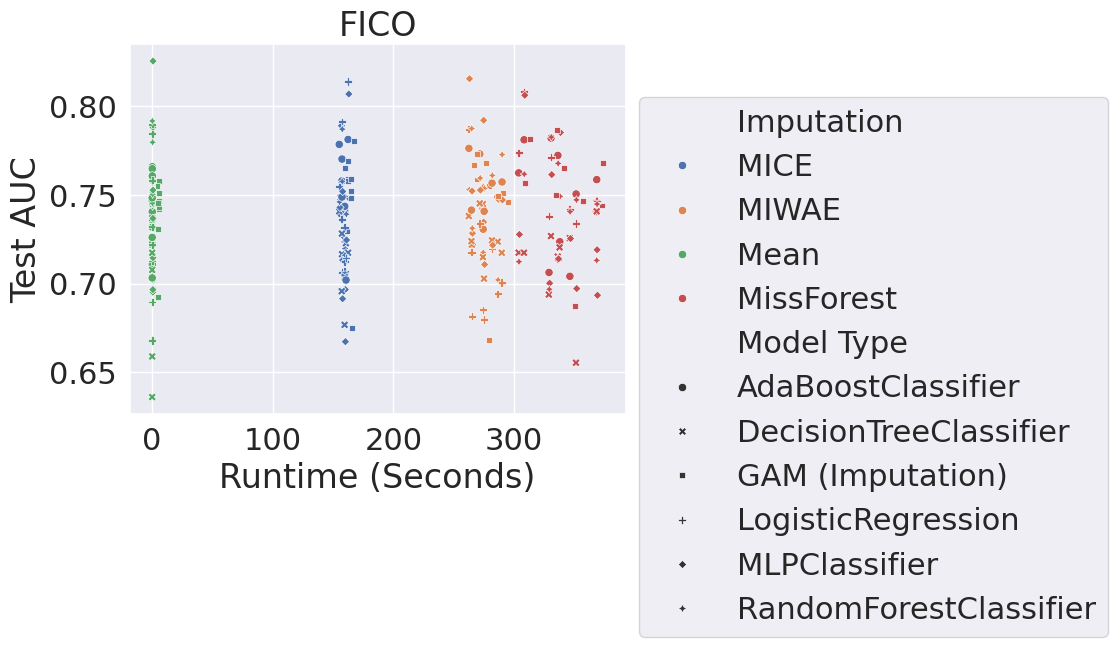

In [24]:
import seaborn as sns
from matplotlib import pyplot as plt
#stacked_time_df_fico = stacked_time_df[stacked_time_df['data_type'] != 'BREAST_CANCER']
color_pal = sns.color_palette()
'''g = sns.FacetGrid(
    merged_df[merged_df['dataset'] == 'FICO'], 
    col="imputation", 
    col_wrap=2, 
    height=6, 
    sharey=True,
    sharex=False)
g.map_dataframe(sns.scatterplot,
    x='time_overall',
    y='metric_value_test',
    hue='model_type',
    #label="Model Fit Time",
    #errorbar='se'
    #hue='model'
)
g.add_legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2)
g.set_xlabels('')'''

sns.set(font_scale=2.0)
g = sns.scatterplot(
    data=merged_df,
    x='time_overall',
    y='metric_value_test',
    hue='Imputation',
    style='Model Type'
    #label="Model Fit Time",
    #errorbar='se'
    #hue='model'
)
#g.set_xticklabels([m for m in stacked_time_df_fico['model_nice'].unique()], rotation=45, ha='right')
g.set_xlabel('Runtime (Seconds)')
g.set_ylabel('Test AUC')
g.set_title('FICO')
#g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.55), ncol=2)
g.legend(loc='upper center', bbox_to_anchor=(1.5, 0.9), ncol=1)
#g.set_ylabel('Time (Seconds)')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

#for ax, title in zip(g.axes.flat, ['FICO (1,883 Samples)', 'FICO (3,765 Samples)', 'FICO (5,648 Samples)', 
#                                    'FICO (7,530 Samples)']):
#    ax.set_title(title)
plt.show()

### Load in data for different numbers of imputations

In [25]:
combined_acc_df.columns

Index(['metric', 'metric_value_train', 'metric_value_test', 'model_type',
       'missingness_handling', 'holdout_set', 'std_fit_time', 'mean_fit_time',
       'num_imputations', 'dataset'],
      dtype='object')

In [26]:
# Load in model fitting data
'''import pandas as pd
df_list = []
for n_imps in [1, 5, 10, 20, 30]:
    df_acc = pd.read_csv(f'full_baseline_results_many_clf_tmp_multi_2024-01-28_10_holdouts_FICO_{n_imps}_imp.csv')
    df_acc = df_acc[df_acc['metric'] == 'acc']
    
    df_list.append(df_acc)
df_acc = pd.concat(df_list, axis=0)
df_acc['model_type'].value_counts()'''

df_acc = combined_acc_df[(combined_acc_df['missingness_handling'] == 'MICE') \
                        & (combined_acc_df['dataset'] == 'FICO')\
                        & (combined_acc_df['metric'] == 'acc')\
                        & (combined_acc_df['model_type'] != 'GAM_aug')\
                        & (combined_acc_df['model_type'] != 'GAM_ind')\
                        & (combined_acc_df['model_type'] != 'GAM_no_missing')]

In [27]:
import pandas as pd
df_list = []
for dataset in ['FICO']:
    try:
        df_list.append(pd.read_csv(f'../../handling_missing_data/timing_stats_10_val_2024-01-27_all_{dataset}.csv'))
    except:
        df_list.append(pd.read_csv(f'../../handling_missing_data/timing_stats_10_val_2024-01-27_all_{dataset}.csv'))
base_timing_df = pd.concat(df_list, axis=0)
base_timing_df['dataset'].value_counts()

FICO    1500
Name: dataset, dtype: int64

In [28]:
imp_counts_to_consider = [1, 5, 10, 20, 30]
df_list = []
for i in imp_counts_to_consider:
    cur_acc_df = df_acc[df_acc['num_imputations'] == i].reset_index()
    cur_acc_df = cur_acc_df[cur_acc_df['model_type'] != 'GAM_ind']
    cur_acc_df = cur_acc_df[cur_acc_df['model_type'] != 'GAM_aug']

    cur_acc_df['Model Type'] = cur_acc_df['model_type']
    cur_acc_df.loc[cur_acc_df['Model Type'] == 'GAM_imputation', 'Model Type'] = 'GAM (Imputation)'

    tmp_df = base_timing_df[base_timing_df['m'] < i].groupby(['dataset', 'holdout_set', 'validation_set']).sum()
    tmp_df = tmp_df.groupby(['dataset', 'holdout_set']).mean().add_suffix('_agg').reset_index()
    #tmp_df = base_timing_df[base_timing_df['m'] < i].groupby(['dataset', 'holdout_set']).sum().add_suffix('_agg').reset_index()
    #tmp_df = tmp_df.groupby('dataset').mean().reset_index()
    tmp_df['num_imputations'] = i

    tmp_df = tmp_df.merge(cur_acc_df, on=['num_imputations', 'holdout_set'], how='outer')

    df_list.append(tmp_df)
df_agg = pd.concat(df_list, axis=0)
df_agg['time_overall'] = df_agg['time_overall_agg'] + df_agg['mean_fit_time']

/tmp/ipykernel_200020/3334614865.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df = base_timing_df[base_timing_df['m'] < i].groupby(['dataset', 'holdout_set', 'validation_set']).sum()
/tmp/ipykernel_200020/3334614865.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp_df = base_timing_df[base_timing_df['m'] < i].groupby(['dataset', 'holdout_set', 'validation_set']).sum()
/tmp/ipykernel_200020/3334614865.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select onl

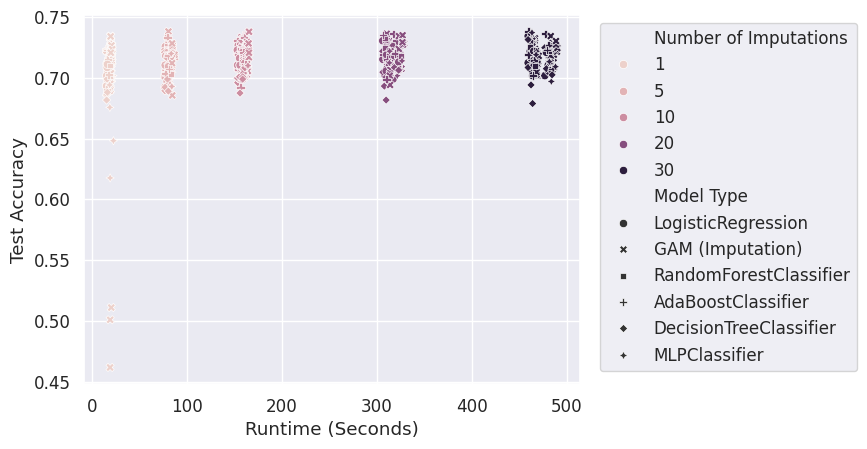

In [29]:
import seaborn as sns
sns.set(font_scale=1.1)
#df_agg['Model Type'] = df_agg['model_type']
df_agg['Number of Imputations'] = df_agg['num_imputations']
g = sns.scatterplot(
    data=df_agg,
    x='time_overall',
    y='metric_value_test',
    hue='Number of Imputations',
    style='Model Type',
)
g.set_xlabel('Runtime (Seconds)')
g.set_ylabel('Test Accuracy')
g.legend(loc='upper center', bbox_to_anchor=(1.3, 1.0), ncol=1)

### Getting runtime for different subsets of a dataset

In [31]:
# Load in model fitting data
import pandas as pd
dataset_of_interest = 'CKD'
imputation_of_interest = 'Mean'
#base_timing_df = pd.concat([
#    pd.read_csv(f'../../handling_missing_data/timing_stats_10_val_2024-01-27_all_{dataset_of_interest}.csv'),
#    pd.read_csv(f'../../handling_missing_data/timing_stats_10_val_2024-01-27_all_{dataset_of_interest}_0.25.csv'),
#    pd.read_csv(f'../../handling_missing_data/timing_stats_10_val_2024-01-27_all_{dataset_of_interest}_0.5.csv'),
#    pd.read_csv(f'../../handling_missing_data/timing_stats_10_val_2024-01-27_all_{dataset_of_interest}_0.75.csv')
#], axis=0)

df_list = []
for ds_name in [dataset_of_interest]:
    for imputation_method in [imputation_of_interest]:
        for subsample in ['', '_0.25', '_0.5']:#, '_0.75']:
            df_list.append(pd.read_csv(f'../../handling_missing_data/timing_stats_{ds_name}{subsample}_{imputation_method}_5_3.csv'))
base_timing_df = pd.concat(df_list, axis=0)
base_timing_df = base_timing_df[base_timing_df['m'] < 10]

mask = (combined_acc_df['num_imputations'] == 10)
acc_df = combined_acc_df[mask]
if dataset_of_interest == 'BREAST_CANCER':
    acc_df = acc_df[acc_df['metric'] == 'auc']
else:
    acc_df = acc_df[acc_df['metric'] == 'acc']

In [33]:
base_timing_df['dataset'].unique()

array(['CKD', 'CKD_0.25', 'CKD_0.5'], dtype=object)

In [19]:
acc_df.groupby(['dataset', 'model_type']).mean()['mean_fit_time']

/tmp/ipykernel_3556993/4150114583.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  acc_df.groupby(['dataset', 'model_type']).mean()['mean_fit_time']


dataset  model_type            
CKD      GAM_aug                   0.497911
         GAM_ind                   0.122794
         GAM_no_missing            0.071101
         LogisticRegression        0.144658
         RandomForestClassifier    0.122257
Name: mean_fit_time, dtype: float64

In [20]:
base_timing_df = base_timing_df.groupby(['holdout_set', 'dataset', 'validation_set']).sum().reset_index()
#base_timing_df = base_timing_df.groupby(['holdout_set', 'dataset']).mean().reset_index()
#base_timing_df
#base_timing_df['holdout_set'].value_counts()

/tmp/ipykernel_3556993/851046216.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  base_timing_df = base_timing_df.groupby(['holdout_set', 'dataset', 'validation_set']).sum().reset_index()


In [21]:
acc_df = acc_df.groupby(['dataset', 'holdout_set', 'model_type']).mean().reset_index()#['holdout_set'].value_counts()

merged_df = base_timing_df.merge(acc_df, how='inner', on=['dataset','holdout_set'])

mask = (merged_df['model_type'] != 'GAM_ind') & (merged_df['model_type'] != 'GAM_aug')
merged_df['impute_time'] = merged_df['time_overall']
merged_df['overall_time'] = 0
merged_df.loc[mask, 'overall_time'] = merged_df.loc[mask, 'impute_time'] + merged_df.loc[mask, 'mean_fit_time']
merged_df.loc[~mask, 'overall_time'] = merged_df.loc[~mask,'mean_fit_time']
merged_df.loc[~mask, 'impute_time'] = 0

/tmp/ipykernel_3556993/358402466.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  acc_df = acc_df.groupby(['dataset', 'holdout_set', 'model_type']).mean().reset_index()#['holdout_set'].value_counts()


In [22]:
merged_df = merged_df[merged_df['model_type'] != 'GAM_no_missing']

In [23]:
#if dataset_of_interest == 'FICO':
#    merged_df = pd.concat([
#        merged_df[merged_df['dataset'] == 'FICO_0.25'],
#        merged_df[merged_df['dataset'] == 'FICO_0.5'],
#        merged_df[merged_df['dataset'] == 'FICO_0.75'],
#        merged_df[merged_df['dataset'] == 'FICO'],
#    ], axis=0)
#else:
#    merged_df = pd.concat([
#        merged_df[merged_df['dataset'] == 'BREAST_CANCER_0.25'],
#        merged_df[merged_df['dataset'] == 'BREAST_CANCER_0.5'],
#        merged_df[merged_df['dataset'] == 'BREAST_CANCER_0.75'],
#        merged_df[merged_df['dataset'] == 'BREAST_CANCER'],
#    ], axis=0)

In [24]:
mask = merged_df['model_type'] == 'GAM_aug'
merged_df.loc[mask, 'model_type'] = 'GAM (Interactions)'
mask = merged_df['model_type'] == 'GAM_ind'
merged_df.loc[mask, 'model_type'] = 'GAM (Indicators)'
mask = merged_df['model_type'] == 'GAM_imputation'
merged_df.loc[mask, 'model_type'] = 'GAM (Imputation)'

"""mask = merged_df['dataset'] == 'FICO'
merged_df.loc[mask, 'dataset'] = 'FICO (7,530 Samples)'
mask = merged_df['dataset'] == 'FICO_0.25'
merged_df.loc[mask, 'dataset'] = 'FICO (1,883 Samples)'
mask = merged_df['dataset'] == 'FICO_0.5'
merged_df.loc[mask, 'dataset'] = 'FICO (3,765 Samples)'
mask = merged_df['dataset'] == 'FICO_0.75'
merged_df.loc[mask, 'dataset'] = 'FICO (5,648 Samples)'"""

"mask = merged_df['dataset'] == 'FICO'\nmerged_df.loc[mask, 'dataset'] = 'FICO (7,530 Samples)'\nmask = merged_df['dataset'] == 'FICO_0.25'\nmerged_df.loc[mask, 'dataset'] = 'FICO (1,883 Samples)'\nmask = merged_df['dataset'] == 'FICO_0.5'\nmerged_df.loc[mask, 'dataset'] = 'FICO (3,765 Samples)'\nmask = merged_df['dataset'] == 'FICO_0.75'\nmerged_df.loc[mask, 'dataset'] = 'FICO (5,648 Samples)'"

In [28]:
merged_df['dataset'].unique()

array(['CKD'], dtype=object)

In [26]:
merged_df = merged_df.sort_values('model_type')
"""if dataset_of_interest == 'FICO':
    merged_df = pd.concat([
        merged_df[merged_df['dataset'] == 'FICO (1,883 Samples)'],
        merged_df[merged_df['dataset'] == 'FICO (3,765 Samples)'],
        merged_df[merged_df['dataset'] == 'FICO (5,648 Samples)'],
        merged_df[merged_df['dataset'] == 'FICO (7,530 Samples)'],
    ], axis=0)
else:
    merged_df = pd.concat([
        merged_df[merged_df['dataset'] == 'BREAST_CANCER_0.25'],
        merged_df[merged_df['dataset'] == 'BREAST_CANCER_0.5'],
        merged_df[merged_df['dataset'] == 'BREAST_CANCER_0.75'],
        merged_df[merged_df['dataset'] == 'BREAST_CANCER'],
    ], axis=0)"""

"if dataset_of_interest == 'FICO':\n    merged_df = pd.concat([\n        merged_df[merged_df['dataset'] == 'FICO (1,883 Samples)'],\n        merged_df[merged_df['dataset'] == 'FICO (3,765 Samples)'],\n        merged_df[merged_df['dataset'] == 'FICO (5,648 Samples)'],\n        merged_df[merged_df['dataset'] == 'FICO (7,530 Samples)'],\n    ], axis=0)\nelse:\n    merged_df = pd.concat([\n        merged_df[merged_df['dataset'] == 'BREAST_CANCER_0.25'],\n        merged_df[merged_df['dataset'] == 'BREAST_CANCER_0.5'],\n        merged_df[merged_df['dataset'] == 'BREAST_CANCER_0.75'],\n        merged_df[merged_df['dataset'] == 'BREAST_CANCER'],\n    ], axis=0)"

/home/users/jcd97/missing_data/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/users/jcd97/missing_data/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


IndexError: index -2 is out of bounds for axis 0 with size 1

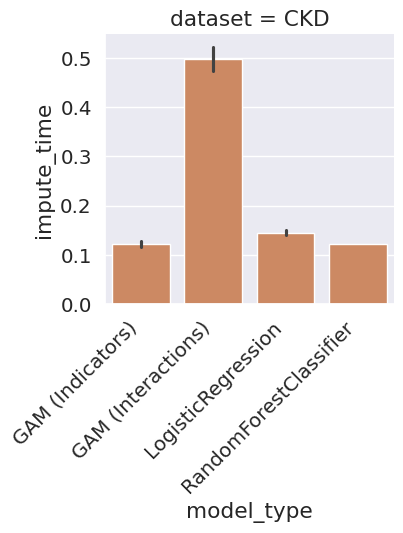

In [27]:
color_pal = sns.color_palette()
sns.set(font_scale=1.3)
g = sns.FacetGrid(
    merged_df, 
    col="dataset", 
    col_wrap=2, 
    height=4, 
    sharey=True)
g.map_dataframe(sns.barplot,
    x='model_type',
    y='overall_time',
    color=color_pal[1],
    label="Model Fit Time"
    #hue='model'
)
g.map_dataframe(sns.barplot,
    x='model_type',
    y='impute_time',
    color=color_pal[0],
    label="Imputation Time"
    #hue='model'
)
g.set_xticklabels([m for m in merged_df['model_type'].unique()],
                    rotation=45, ha='right')

for tick_in, tick_label in enumerate(g.axes[-2].xaxis.get_ticklabels()):
    if merged_df['model_type'].unique()[tick_in] in ['GAM (Interactions)', 'GAM (Indicators)']:
        #tick_label.set_color("red")
        tick_label.set_font({'weight': 'bold'})
    else:
        tick_label.set_color("black")

for tick_in, tick_label in enumerate(g.axes[-1].xaxis.get_ticklabels()):
    if merged_df['model_type'].unique()[tick_in] in ['GAM (Interactions)', 'GAM (Indicators)']:
        #tick_label.set_color("red")
        tick_label.set_font({'weight': 'bold'})
    else:
        tick_label.set_color("black")
    
g.set_xlabels('')
g.set_ylabels('Time (Seconds)')

if dataset_of_interest == 'FICO':
    for ax, title in zip(g.axes.flat, ['FICO \n(2,615 Samples)', 'FICO \n(5,230 Samples)', 
                                        'FICO \n(7,844 Samples)', 'FICO \n(10,459 Samples)']):
        ax.set_title(title)
else:
    for ax, title in zip(g.axes.flat, ['Breast Cancer \n(439 Samples)', 'Breast Cancer \n(878 Samples)', 
                                        'Breast Cancer \n(1,317 Samples)', 'Breast Cancer \n(1,756 Samples)']):
        ax.set_title(title)
plt.tight_layout()
g.add_legend()
sns.move_legend(g, "upper left", bbox_to_anchor=(0.25, 1.05), ncol=2)
plt.show()